In [431]:
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from tqdm.auto import tqdm
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
import gin
gin.enter_interactive_mode()

In [432]:
@gin.configurable
def get_xy(h=10, w=10, s=1000):
    res = np.zeros((s, h, w), dtype=np.float32)
    idxes_x = np.random.choice(h, s, replace=True)
    idxes_y = np.random.choice(w, s, replace=True)
    res[np.arange(s), idxes_x, idxes_y] = 1.0
    
    return res, (idxes_x, idxes_y)

In [433]:
h, w, s = 10, 10, 1000
gin.bind_parameter('get_xy.h', h)
gin.bind_parameter('get_xy.w', w)
gin.bind_parameter('get_xy.s', s)

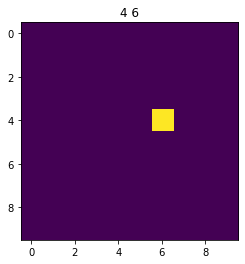

In [434]:
X, (xs, ys) = get_xy()

idx = np.random.choice(s)

plt.title(f"{xs[idx]} {ys[idx]}")
plt.imshow(X[idx])

In [444]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(in_features=h * w, out_features=4)
        self.fc2 = nn.Linear(in_features=10, out_features=4)
        self.act = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm1d(h * w)
        self.bn2 = nn.BatchNorm1d(10)
    def forward(self, x):
        x = x.flatten(start_dim=1)
#         x = self.bn1(x)
        x = self.fc1(x)
#         x = self.bn2(self.act(self.fc1(x)))
#         x = self.fc2(x)
        return x
class Reconstructor(nn.Module):
    def __init__(self):
        super(Reconstructor, self).__init__()
        self.fc1 = nn.Linear(in_features=4, out_features=100 * h * w)
        self.fc2 = nn.Linear(in_features=100 * h * w, out_features=h * w)
        self.act = nn.Tanh()
#         self.bn1 = nn.BatchNorm1d(4)
#         self.bn2 = nn.BatchNorm1d(100 * h * w)
#         self.bnf = nn.BatchNorm1d(h * w)
    def forward(self, x):
#         x = self.bn1(x)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
#         x = self.bnf(x)
        x = x.view(x.shape[0], h, w)
        return x

In [445]:
rec = Reconstructor().cuda()
dec = Decoder().cuda()

In [446]:
data = torch.from_numpy(X)

In [447]:
def loss():
#     softmaxed = torch.nn.Softmax(1)(rec(dec(data)).flatten(start_dim=1))
#     answers = torch.argmax(data.flatten(start_dim=1), dim=1)
    
#     ce = torch.nn.CrossEntropyLoss()
#     loss = ce(softmaxed, answers)
   
    delta = (rec(dec(data)) - data).flatten(start_dim=1)
    std = data.std(0, keepdim=True).flatten(start_dim=1)
    std = torch.where(std < 1e-6, torch.ones_like(std), std)
    delta = delta.pow(2)
    delta = delta / std.pow(2)
    loss = delta.sum(1).mean(0)
    return loss

In [448]:
opt = torch.optim.Adam(list(rec.parameters()) + list(dec.parameters()),
                       lr=1e-3)

In [449]:
losses = []

In [450]:
for i in tqdm(range(10000)):
    if i % 10 == 0:
        X, (xs, ys) = get_xy()
        data = torch.from_numpy(X).cuda()
    
    opt.zero_grad()
    l = loss()
    l.backward()
    opt.step()
    losses.append(l.item())

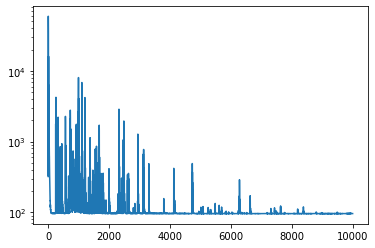

In [451]:
plt.plot(losses)
plt.yscale('log')

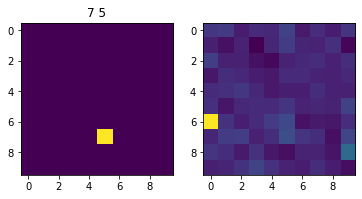

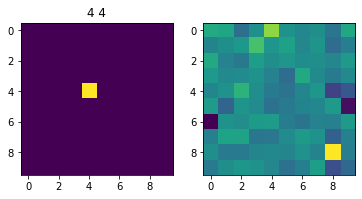

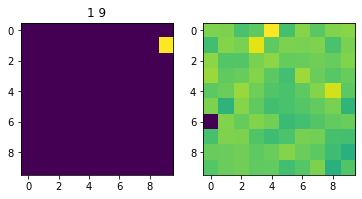

In [452]:
X, (xs, ys) = get_xy()
data = torch.from_numpy(X).cuda()

Xrec = rec(dec(data))
for _ in range(3):
    idx = np.random.choice(s)

    plt.subplot(1, 2, 1)
    plt.title(f"{xs[idx]} {ys[idx]}")
    plt.imshow(X[idx])
    plt.subplot(1, 2, 2)
    xrecnp = Xrec.detach().cpu().numpy()[idx]
    plt.imshow(xrecnp)# >= np.max(xrecnp))
    plt.show()

# Combined model

In [404]:
from sparse_causal_model_learner_rl.trainable.combined import FCCombinedModel

In [405]:
class Rec(nn.Module):
    def __init__(self):
        super(Rec, self).__init__()
        self.rec_comb = FCCombinedModel(hidden_sizes=[h * w], activation_cls=nn.Tanh, input_shape=(4,),
                           output_shape=(1,), n_models=h * w)
    def forward(self, x):
        x = x.view(*x.shape, 1).expand(*[-1] * len(x.shape), h * w)
        return self.rec_comb(x).view(x.shape[0], h, w)

In [406]:
dec = Decoder().cuda()
rec = Rec().cuda()

In [407]:
opt = torch.optim.Adam(list(rec.parameters()) + list(dec.parameters()),
                       lr=1e-3)

In [408]:
losses = []

In [414]:
for i in tqdm(range(10000)):
    if i % 10 == 0:
        X, (xs, ys) = get_xy()
        data = torch.from_numpy(X).cuda()
    
    opt.zero_grad()
    l = loss()
    l.backward()
    opt.step()
    losses.append(l.item())

KeyboardInterrupt: 

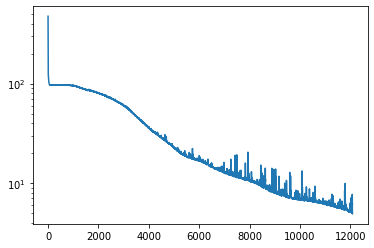

In [415]:
plt.plot(losses)
plt.yscale('log')

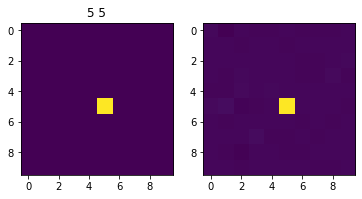

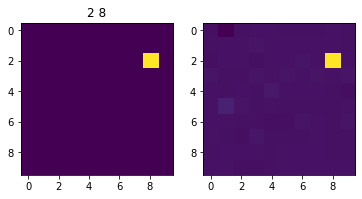

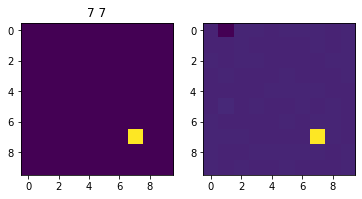

In [416]:
X, (xs, ys) = get_xy()
data = torch.from_numpy(X).cuda()

Xrec = rec(dec(data))

for _ in range(3):
    idx = np.random.choice(s)

    plt.subplot(1, 2, 1)
    plt.title(f"{xs[idx]} {ys[idx]}")
    plt.imshow(X[idx])
    plt.subplot(1, 2, 2)
    xrecnp = Xrec.detach().cpu().numpy()[idx]
    plt.imshow(xrecnp)# >= np.max(xrecnp))
    plt.show()